In [1]:
from datetime import datetime
import gzip
import os
import stat

import altair as alt
import pandas as pd

## GISAID genomic epidemiology metadata

From GISAID's EpiCov, download the metadata file from the _Genomic epidemiology_ section. **Note**: do not download the metadata file from the _Download packages_ section.

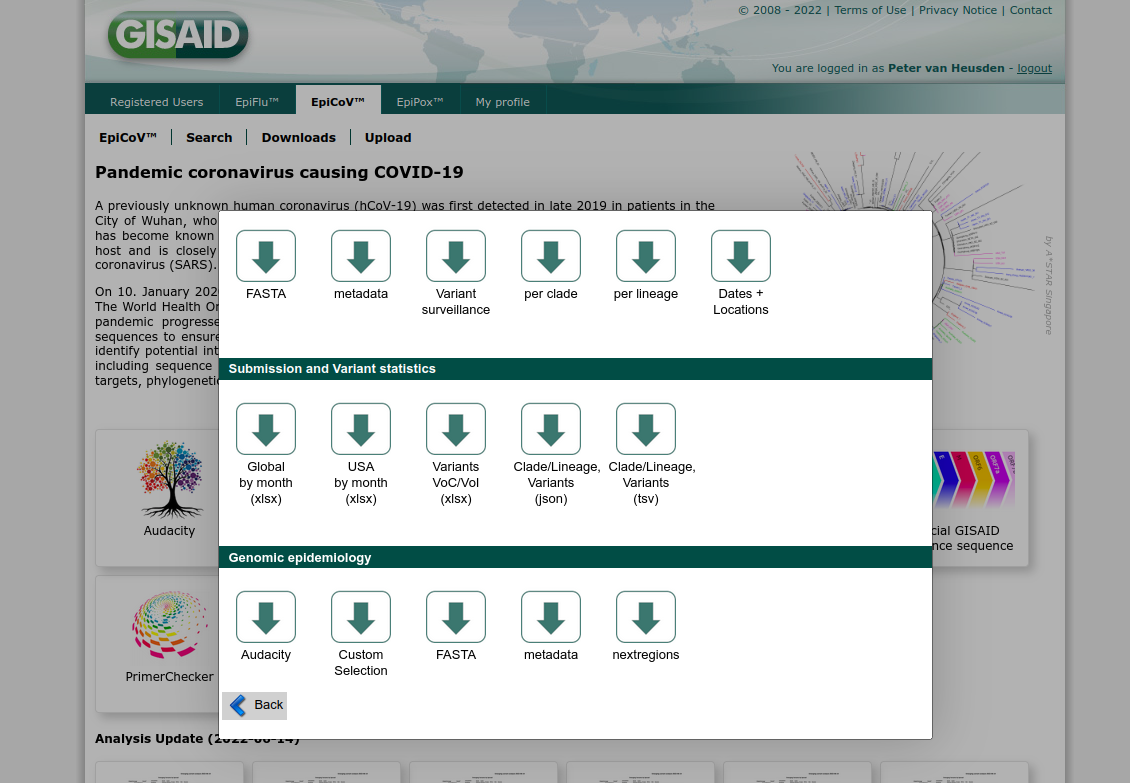


In [2]:
# starting point is GISAID metadata file
# download it from 
gisaid_metadata_filename = 'metadata_2022-06-12_23-58.tsv.gz'

In [3]:
# extract only African data from metadata file.
# this code checks if the metadata file is newer than the "metadata.tsv" and only replaces the "metadata.tsv" if the metadata file is newer
first_line_seen = False
total_genomes = 0

metadata_filename = 'metadata.tsv'
if os.stat(gisaid_metadata_filename).st_mtime > os.stat(metadata_filename).st_mtime:
    with gzip.open(gisaid_metadata_filename, 'rb') as infile:
        with open(metadata_filename, 'w') as outfile:
            for line in infile:
                line_str = line.decode('utf')
                if not first_line_seen:
                    outfile.write(line_str)
                    first_line_seen = True
                fields = line_str.split('\t')
                total_genomes += 1
                if fields[5] == 'Africa':
                    outfile.write(line_str)


In [4]:
# Country codes, names, continents
countries = pd.read_csv(
    "https://pkgstore.datahub.io/JohnSnowLabs/country-and-continent-codes-list/country-and-continent-codes-list-csv_csv/data/b7876b7f496677669644f3d1069d3121/country-and-continent-codes-list-csv_csv.csv"
)

In [5]:
country_income_classification = pd.read_excel('https://databank.worldbank.org/data/download/site-content/CLASS.xlsx', sheet_name='List of economies', usecols=range(4), nrows=218).fillna('Unknown')
class_codes = {
    'High income': 'HIC', 
    'Low income': 'LIC', 
    'Lower middle income': 'LMIC',
    'Upper middle income': 'UMIC', 
    'Unknown': 'UNK'
}
country_income_classification['income_code'] = country_income_classification['Income group'].apply(lambda c: class_codes[c])


In [6]:
def handle_two_part_dates(date):
    parts = date.split("-")
    if len(parts) == 2:
        parts.append("1")
    date = "-".join(parts)
    return date
africa_metadata = pd.read_csv('metadata.tsv', delimiter='\t', index_col=0)
africa_metadata.date = africa_metadata.date.apply(handle_two_part_dates)

#ensure that date is valid before any further processing
def is_date_valid(date):
    try:
        datetime.strptime(date, "%Y-%m-%d")
    except ValueError:
        return False
    return True
    
africa_metadata = africa_metadata[africa_metadata.date.apply(is_date_valid)]

# africa_metadata = gisaid_metadata[gisaid_metadata.region == "Africa"]
# only retain things with good dates
africa_metadata = africa_metadata[
    africa_metadata.apply(lambda x: len(x["date"].split("-")) == 3, axis=1)
]
# drop things without a Nextstrain clade - these are typically poor quality
africa_metadata = africa_metadata[africa_metadata.Nextstrain_clade.notna()]

# fix up a submitting lab names
africa_metadata.loc[
    africa_metadata.submitting_lab
    == "KRISP, KZn Research Innovation and Sequencing Platform",
    "submitting_lab",
] = "KRISP, KZN Research Innovation and Sequencing Platform"
africa_metadata.loc[africa_metadata.submitting_lab.isin(
    ['CERI, Centre for Epidemic Response and Innvoation, Stellenbosch University and KRISP, KZN Research Innovation and Sequencing Platform, UKZN.',
    'CERI, Centre for Epidemic Response and Innovation, Stellenbosch Univeristy & KRISP, KZN Research Innovation and Sequencing Platform',
    'CERI, Centre for Epidemic Response and Innovation, Stellenbosch University and KRISP, KZN Research Innovation and Sequencing Platform, UKZN.'
    'CERI, Centre for Epidemic Response and Innovation, Stellenbosch University and CERI-KRISP, KZN Research Innovation and Sequencing Platform']), 
                    "submitting_lab"] = 'CERI, Centre for Epidemic Response and Innovation'
africa_metadata.loc[africa_metadata.submitting_lab.isin(
    ['National Health Laboratory Service/University of Cape Town (National Health Laboratory Service/University of Cape Town (NHLS/UCT))',
     'National Health Laboratory Service/University of Cape Town (NHLS/UCT)',
     'National Health Laboratory Service/UCT']), "submitting_lab"] = 'NHLS/UCT'
africa_metadata.loc[africa_metadata.submitting_lab.isin(
    ['National Health Laboratory Service (NHLS), Tygerberg',
     'Division of Medical Virology, Stellenbosch University and National Health Laboratory Service (NHLS)',
     'Division of Medical Virology, National Health Laboratory Service (NHLS), Tygerberg Hospital / Stellenbosch University',
     'Stellenbosch University and NHLS',
     'National Health Laboratory Services, Virology']), "submitting_lab"] = 'Division of Medical Virology, Stellenbosch University and NHLS Tygerberg Hospital'
africa_metadata.loc[africa_metadata.submitting_lab == 'ZARV, Department Mdeical Virology, University of Pretoria', 
                    "submitting_lab"] = 'ZARV, Department Medical Virology, University of Pretoria'
africa_metadata.loc[
    africa_metadata.submitting_lab
    == "Where sequence data have been generated and submitted to GISAID",
    "submitting_lab",
] = "MRC/UVRI & LSHTM Uganda Research Unit"
africa_metadata.loc[
    africa_metadata.submitting_lab == "KEMRI-Wellcome Trust Research Programme,Kilifi",
    "submitting_lab",
] = "KEMRI-Wellcome Trust Research Programme/KEMRI-CGMR-C Kilifi"
africa_metadata.loc[
    (africa_metadata.country == "Nigeria")
    & (
        africa_metadata.submitting_lab.str.startswith(
            "African Centre of Excellence for Genomics of Infectious Diseases"
        )
    ),
    "submitting_lab",
] = "ACEGID, African Centre of Excellence for Genomics of Infectious Diseases, Redeemer’s University, Ede"
africa_metadata.loc[
    africa_metadata.submitting_lab == "Redeemer's University, ACEGID", "submitting_lab"
] = "ACEGID, African Centre of Excellence for Genomics of Infectious Diseases, Redeemer’s University, Ede"
africa_metadata.loc[
    (africa_metadata.country == "Nigeria")
    & (africa_metadata.submitting_lab.str.startswith("National")),
    "submitting_lab",
] = "NCDC, National Reference Laboratory, Nigeria Centre for Disease Control, Gaduwa, Abuja, Nigeria"
africa_metadata.loc[
    (africa_metadata.country == "Democratic Republic of the Congo")
    & (
        africa_metadata.submitting_lab
        == "Pathogen Sequencing Lab, National Institute for Biomedical Research (INRB)"
    ),
    "submitting_lab",
] = "INRB, Pathogen Sequencing Lab, National Institute for Biomedical Research"

# add date year / month fields
africa_metadata["date_yearmon"] = africa_metadata.apply(
    lambda r: "-".join(r.date.split("-")[:-1]), axis=1
)
africa_metadata["date_submitted_yearmon"] = africa_metadata.apply(
    lambda r: "-".join(r.date_submitted.split("-")[:-1]), axis=1
)

# calculate the number of days between sample collection and sample submission
africa_metadata["days_to_submit"] = africa_metadata.apply(
    lambda r: int(
        (
            datetime.strptime(r.date_submitted, "%Y-%m-%d")
            - datetime.strptime(r.date, "%Y-%m-%d")
        ).total_seconds()
        // (3600 * 24)
    ),
    axis=1,
)

country_lookup = {}
country_lookup['Democratic Republic of the Congo'] = 'COD'
country_lookup['Cabo Verde'] = 'CPV'
country_lookup["Côte d'Ivoire"] = 'CIV'
country_lookup['Eswatini'] = 'SWZ'
country_lookup['Republic of the Congo'] = 'COG'
country_lookup['Union of the Comoros'] = 'COM'
for country_name in africa_metadata.country.unique():
    if len(countries[countries.Country_Name.str.contains(country_name)]) != 0:
        country_lookup[country_name] = str(countries[countries.Country_Name.str.contains(country_name)].Three_Letter_Country_Code.iloc[0])
    elif country_name in country_lookup:
        pass
    else:
        print(country_name)
africa_metadata['country_iso_3'] = africa_metadata.country.apply(lambda c: country_lookup[c])

africa_metadata['income_group'] = africa_metadata.reset_index().set_index('country_iso_3').join(country_income_classification.set_index('Code')).set_index('strain')['Income group']

# make a dict mapping GISAID country name to ISO 2 letter code
name_to_two_letter_code = {
    "Union of the Comoros": "KM",
    "Republic of the Congo": "CG",
    "Côte d'Ivoire": "CI",
    "Democratic Republic of the Congo": "CD",
    "Eswatini": "SZ",
    "Guinea": "GN",
}
for country_name in africa_metadata.country.unique():
    country_info = countries[countries.Country_Name.str.contains(country_name)]
    if len(country_info) == 1:
        name_to_two_letter_code[country_name] = country_info.iloc[
            0
        ].Two_Letter_Country_Code

### GISAID graphs for an African country

These graphs can be customised for any African country by changing the variables at the top of the code cell

In [7]:
# to adapt this for another country change these variables
country_name = "South Africa"

# do not edit anything below this line
gisaid_data = (
    africa_metadata[africa_metadata.country == country_name]
    .groupby(["date_yearmon", "pango_lineage"])
    .count()
    .reset_index()
)
gisaid = (
    alt.Chart(gisaid_data, width=600, title=f"SARS-CoV-2 surveillance: {country_name}")
    .mark_bar()
    .encode(
        alt.X("date_yearmon", title="Year / Month"),
        y=alt.Y("sum(virus)", title="Samples by Date of Sample"),
        color=alt.Color("pango_lineage", sort="-y"),
        tooltip=["pango_lineage", "virus"],
    )
)
gisaid

alt.Chart(...)

In [8]:
# Our World In Data COVID-19 info
owid_data = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")
owid_data["year_mon"] = owid_data.apply(
    lambda r: "-".join(r.date.split("-")[:-1]), axis=1
)

In [9]:
# this graph adds the case data from Our World in Data
# it has two parameters - the Country Name and the ISO 3 letter country code
country_name = "South Africa"
country_code = "ZAF"

# do not edit anything below this line
gisaid_data = (
    africa_metadata[africa_metadata.country == country_name]
    .groupby(["date_yearmon", "pango_lineage"])
    .count()
    .reset_index()
)
sa_owid_data = (
    owid_data[owid_data.iso_code == country_code]
    .groupby(["year_mon"])
    .new_cases.mean()
    .reset_index()
)
gisaid = (
    alt.Chart(gisaid_data, width=600, title=f"SARS-CoV-2 surveillance: {country_name}")
    .mark_bar()
    .encode(
        alt.X("date_yearmon", title="Year / Month"),
        y=alt.Y("sum(virus)", title="Samples by Date of Sample"),
        color=alt.Color("pango_lineage", sort="-y"),
        tooltip=["pango_lineage", "virus"],
    )
)
owid = (
    alt.Chart(sa_owid_data)
    .mark_line(stroke="red", interpolate="monotone")
    .encode(
        alt.X("year_mon", title="Year / Month"),
        alt.Y("new_cases", title="New Cases / Day"),
    )
)
alt.layer(gisaid, owid).resolve_scale(y="independent")

alt.LayerChart(...)

## Other charts

These are not for country level reporting but illustrate other features of the GISAID Africa data

In [10]:
# SARS-CoV-2 sequence data in GISAID for all African countries
alt.Chart(
    africa_metadata.groupby(["date_yearmon", "country"]).count().reset_index(),
    width=600,
).mark_bar().encode(
    x=alt.X("date_yearmon:O", title="Sample Date"),
    y=alt.Y("virus", title="Number of Samples"),
    color=alt.Color("country", sort="-y"),
    tooltip="country",
)

alt.Chart(...)

In [11]:
# country level data by date of data submission
# it has two parameters - the Country Name and the ISO 3 letter country code
country_name = "South Africa"
country_code = "ZAF" 
gisaid_data = (
    africa_metadata[africa_metadata.country == country_name]
    .groupby(["date_submitted_yearmon", "pango_lineage"])
    .count()
    .reset_index()
)
sa_owid_data = (
    owid_data[owid_data.iso_code == country_code]
    .groupby(["year_mon"])
    .new_cases.mean()
    .reset_index()
)
gisaid = (
    alt.Chart(gisaid_data, width=600, title=f"SARS-CoV-2 surveillance: {country_name}")
    .mark_bar()
    .encode(
        alt.X("date_submitted_yearmon", title="Year / Month"),
        y=alt.Y("sum(virus)", title="Samples by Date of Submission"),
        color=alt.Color("pango_lineage", sort="-y"),
        tooltip=["pango_lineage", "virus"],
    )
)
owid = (
    alt.Chart(sa_owid_data)
    .mark_line(stroke="red", interpolate="monotone")
    .encode(
        alt.X("year_mon", title="Year / Month"),
        alt.Y("new_cases", title="New Cases / Day"),
    )
)
alt.layer(gisaid, owid).resolve_scale(y="independent")

alt.LayerChart(...)